In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

In [54]:
df_train = pd.read_pickle('./data/df_train.pkl')
df_test = pd.read_pickle('./data/df_test.pkl')

# Assign Target and Features

In [55]:
X_train = df_train.drop("churn_risk_score", axis = 1)
y_train = df_train["churn_risk_score"]

X_test = df_test.drop("churn_risk_score", axis = 1)
y_test = df_test["churn_risk_score"]

In [56]:
df_train = df_train.astype(float)
y_train = y_train.astype(int)

y_test = y_test.astype(int)

# Logistic Regression

In [57]:
# Instatiate model and fit on train data

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

## Prediction on test data

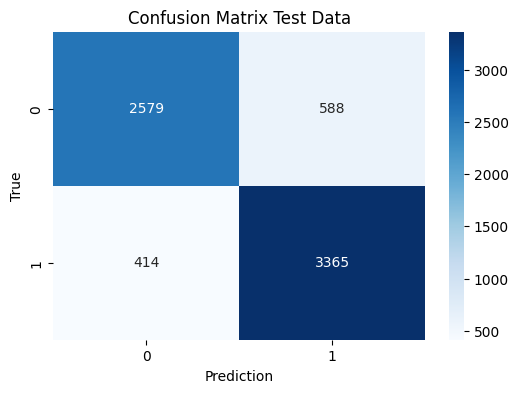

In [58]:
# Make predictions for test set
y_pred = logreg.predict(X_test)

#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=True)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix Test Data')
plt.show()

## Prediction on train data

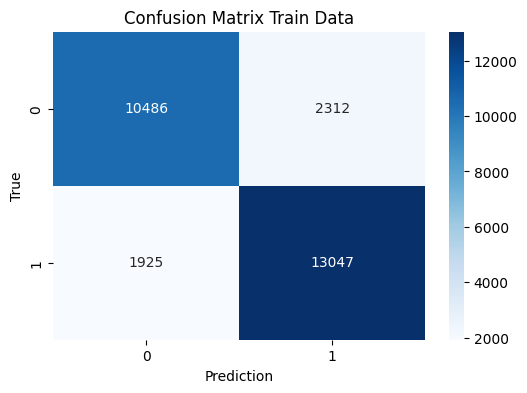

In [59]:
# Make predictions for train set
y_pred_train = logreg.predict(X_train)

#confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_train, annot=True, cmap="Blues", fmt="d", cbar=True)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix Train Data')
plt.show()

## Test Scores

In [60]:
#scores
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Test:", accuracy)

accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy Training:", accuracy)

f1 = f1_score(y_test, y_pred)
print("F1 Test:", f1)

f1 = f1_score(y_train, y_pred_train)
print("F1 Training:", f1)

precision = precision_score(y_test, y_pred)
print("Precision Test:", precision)

precision = precision_score(y_train, y_pred_train)
print("Precision Training:", precision)

recall = recall_score(y_test, y_pred)
print("Recall Test:", recall)

recall = recall_score(y_train, y_pred_train)
print("Recall Training:", recall)

Accuracy Test: 0.8557443132738267
Accuracy Training: 0.8474252790781419
F1 Test: 0.8704086911536473
F1 Training: 0.8603079357752794
Precision Test: 0.8512522135087276
Precision Training: 0.8494693664952145
Recall Test: 0.8904472082561524
Recall Training: 0.8714266631044617


!!! with random-state 42 at train-test-split is the result of Test-data better than Train-data !

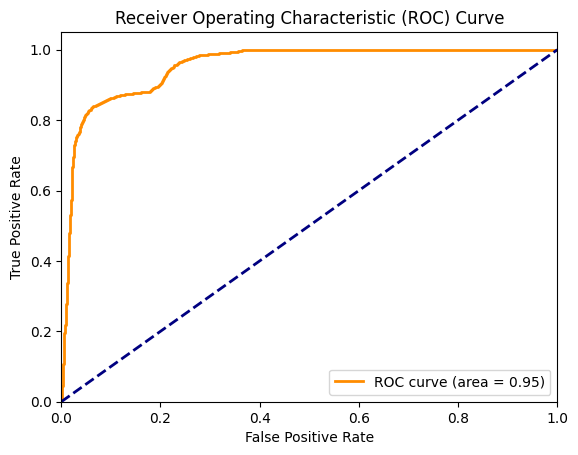

In [61]:
# ROC Curve
y_pred_roc = logreg.predict_proba(X_test)[:, 1] # Probability of positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_roc)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



## Save Model

In [62]:
# Save model
with open('./model/model_logreg.pkl', 'wb') as file:
    pickle.dump(logreg, file)

## Feature Importance

Feature Importance:
                                        Feature  Importance
31                    feedback_Reasonable Price    3.963418
33               feedback_User Friendly Website    3.955433
29            feedback_Products always in Stock    3.818006
30               feedback_Quality Customer Care    3.772606
34                          membership_category    1.531573
4                              points_in_wallet    0.450636
25                    complaint_status_Unsolved    0.177564
27                feedback_Poor Product Quality    0.169683
22              complaint_status_Not Applicable    0.139844
8                                gender_Unknown    0.127142
23                      complaint_status_Solved    0.095844
26               feedback_Poor Customer Service    0.095051
24         complaint_status_Solved in Follow-up    0.080989
15         preferred_offer_types_Without Offers    0.074525
32                        feedback_Too many ads    0.073330
20                  

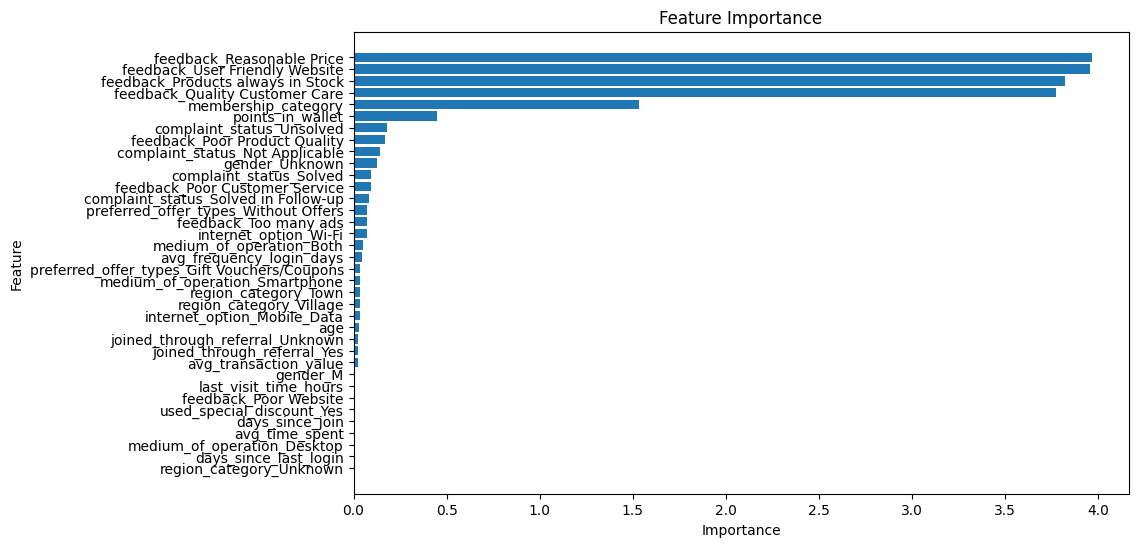

In [63]:
#feature importance
coefficients = logreg.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(coefficients)
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print("Feature Importance:")
print(feature_importance)
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': (coefficients)
    })
coefficients = coefficients.sort_values(by='Importance', ascending=False)
print(coefficients)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Umkehr der Achsen, damit die wichtigsten Features oben sind
plt.show()

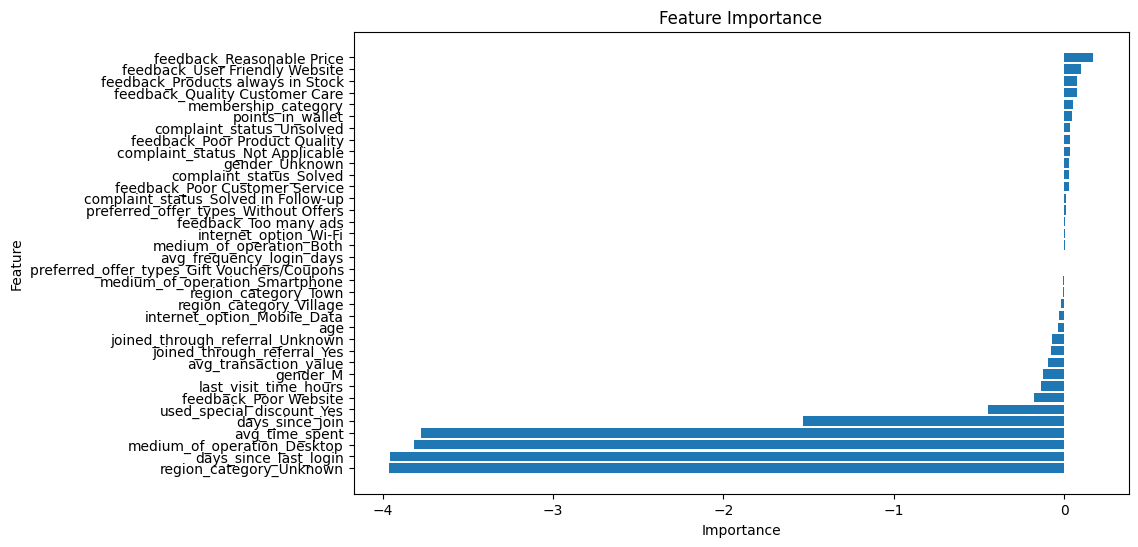

In [64]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], coefficients['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Umkehr der Achsen, damit die wichtigsten Features oben sind
plt.show()

In [65]:
# Erstellen Sie ein neues DataFrame, um die gesamte Wichtigkeit für jedes ursprüngliche Feature zu speichern
original_feature_importances = pd.DataFrame(columns=['Feature', 'Importance'])

for feature, group in feature_importance.groupby(feature_importance['Feature'].str.split('_').str[0]):
    total_importance = group['Importance'].sum()
    original_feature_importances = pd.concat([original_feature_importances, pd.DataFrame([{'Feature': feature, 'Importance': total_importance}])], ignore_index=True)

original_feature_importances = original_feature_importances.sort_values(by='Importance', ascending=False)

# Jetzt enthält `original_feature_importances` die gesamte Wichtigkeit für jedes ursprüngliche Feature
print(original_feature_importances)

       Feature  Importance
4     feedback   15.854922
10  membership    1.531573
2    complaint    0.494241
11      points    0.450636
5       gender    0.136494
12   preferred    0.110580
6     internet    0.104010
9       medium    0.085667
1          avg    0.070671
13      region    0.068517
7       joined    0.052662
0          age    0.029950
8         last    0.008205
14        used    0.006196
3         days    0.005828


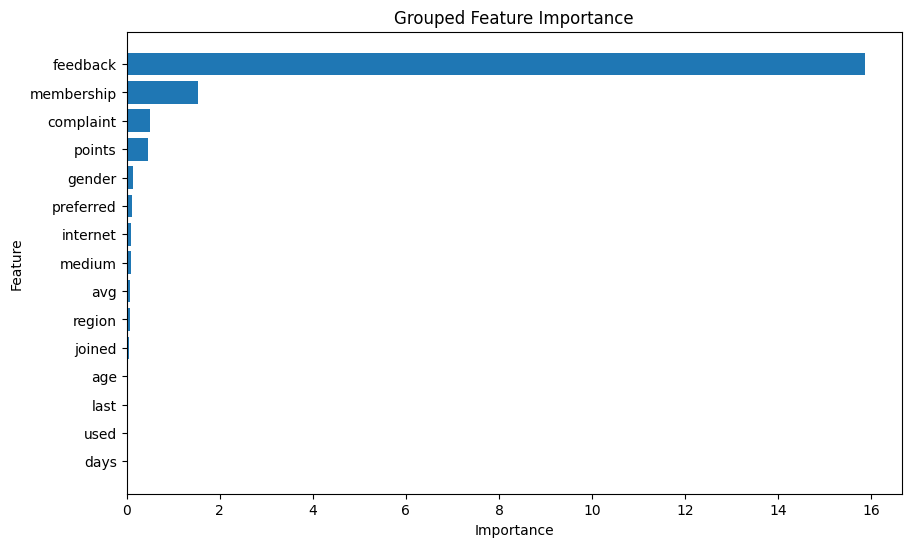

In [66]:
plt.figure(figsize=(10, 6))
plt.barh(original_feature_importances['Feature'], original_feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Grouped Feature Importance')
plt.gca().invert_yaxis()  # Umkehr der Achsen, damit die wichtigsten Features oben sind
plt.show()

# todo
- feature importance for dropped features during one-hot-encoding (does feature importance change when other categories of the same feature are dropped?)
- how to correctly aggregate one-hot-encoded features for feature importance: sum, mean?


In [67]:
# create a data set with the predicted values for evaluation of test-data:
df_test_eval = df_test.copy()
df_test_eval['y_pred'] = y_pred

In [68]:
# create a data set with the predicted values for evaluation of  train-test:
df_train_eval = df_train.copy()
df_train_eval['y_pred'] = y_pred_train

In [69]:
# check if subfolder exists:
if not os.path.exists('./data/eval'):
        os.makedirs('./data/eval')

# write the dataframes with prediction outcome for next notebook 
df_train_eval.to_pickle('./data/eval/df_train_eval.pkl')
df_test_eval.to_pickle('./data/eval/df_test_eval.pkl')